# Task 3 Classification project

In [7]:
#enable auto complete
%config IPCompleter.greedy=True

In [1]:
#import libraries
import os, scipy
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from math import sqrt

#sklearn models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

#model metrics
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline

#dimension reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [9]:
#import dataset
df_credit = pd.read_csv('cleaned_bank_data.csv', index_col = False)

#fix data types
cat_list = [df_credit.SEX, df_credit.EDUCATION, df_credit.MARRIAGE, df_credit.Aug_paid_status, df_credit.July_paid_status, df_credit.Jun_paid_status, df_credit.May_paid_status, df_credit.Apr_paid_status, df_credit['default payment next month'], df_credit.demo_age]
df_credit.SEX, df_credit.EDUCATION, df_credit.MARRIAGE, df_credit.Aug_paid_status, df_credit.July_paid_status, df_credit.Jun_paid_status, df_credit.May_paid_status, df_credit.Apr_paid_status, df_credit['default payment next month'], df_credit.demo_age = [x.astype('int8') for x in cat_list]
df_credit.info()
df_credit.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int8
EDUCATION                     30000 non-null int8
MARRIAGE                      30000 non-null int8
AGE                           30000 non-null int64
demo_age                      30000 non-null int8
Sep_paid_status               30000 non-null int64
Aug_paid_status               30000 non-null int8
July_paid_status              30000 non-null int8
Jun_paid_status               30000 non-null int8
May_paid_status               30000 non-null int8
Apr_paid_status               30000 non-null int8
Sep_bill_amt                  30000 non-null int64
Aug_bill_amt                  30000 non-null int64
July__bill_amt                30000 non-null int64
June__bill_amt                30000 non-null int64
May_bill_amt                  30000 non-null int64
Apr_bill_amt                  300

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,demo_age,Sep_paid_status,Aug_paid_status,July_paid_status,Jun_paid_status,...,June__bill_amt,May_bill_amt,Apr_bill_amt,Sep_paid_amount,Aug_paid_amount,July_paid_amount,June_paid_amount,May_paid_amount,Apr_paid_amount,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.842267,1.551867,35.485500,32.049600,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.744494,0.521970,9.217904,9.454042,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,1.000000,0.000000,21.000000,20.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,26.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,32.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,38.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,74.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [11]:
#removed the following based on correlation matrix generated in T2, all columns below had over 85 % correlation/colinearity with Sep bill amount
df_credit = df_credit.drop(columns = ['Aug_bill_amt', 'July__bill_amt', 'June__bill_amt', 'May_bill_amt'])
df_credit.head(1)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,demo_age,Sep_paid_status,Aug_paid_status,July_paid_status,Jun_paid_status,...,Apr_paid_status,Sep_bill_amt,Apr_bill_amt,Sep_paid_amount,Aug_paid_amount,July_paid_amount,June_paid_amount,May_paid_amount,Apr_paid_amount,default payment next month
0,20000,2,2,1,24,20,2,2,-1,-1,...,-2,3913,0,0,689,0,0,0,0,1


In [15]:
# establish features and dependent variable
df_features = df_credit.iloc[:,:-1]
print(df_features.head(1))

dep_var = df_credit['default payment next month']

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  demo_age  Sep_paid_status  \
0      20000    2          2         1   24        20                2   

   Aug_paid_status  July_paid_status  Jun_paid_status  May_paid_status  \
0                2                -1               -1               -2   

   Apr_paid_status  Sep_bill_amt  Apr_bill_amt  Sep_paid_amount  \
0               -2          3913             0                0   

   Aug_paid_amount  July_paid_amount  June_paid_amount  May_paid_amount  \
0              689                 0                 0                0   

   Apr_paid_amount  
0                0  


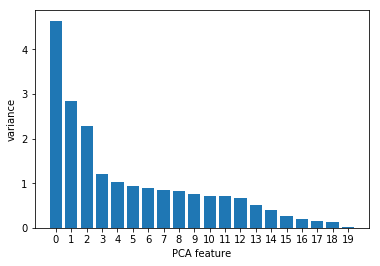

In [16]:
# addition PCA reduction, which requires scaled features
X = StandardScaler().fit_transform(df_features)
pca = PCA()
pca.fit(X)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()


# from graph, pick PCA(n_components = 3)

In [17]:
#test train split
features = df_credit.iloc[:,:-1]
y = df_credit['default payment next month']
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.30, random_state =123)

In [18]:
#standardized KNN
knn_clf = make_pipeline(StandardScaler(), PCA(n_components=3), KNeighborsClassifier())
#print(sorted(knn_clf.get_params().keys()))

knn_grid = {'kneighborsclassifier__n_neighbors':np.arange(5,25,5)}
knn_cv = GridSearchCV(knn_clf, param_grid = knn_grid, cv = 5)
%timeit knn_cv.fit(X_train, y_train)
print("Tuned knn parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))

4.59 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Tuned knn parameters: {'kneighborsclassifier__n_neighbors': 20}
Best score is 0.8032380952380952


In [19]:
#prints pipelinekeys
#print(sorted(rf_clf.get_params().keys()))

#standardized, PCA pipeline

rf_clf = make_pipeline(StandardScaler(), PCA(n_components=3),RandomForestClassifier(random_state = 123))
param_grid = {'randomforestclassifier__n_estimators': np.arange(1, 25, 5),
             'randomforestclassifier__criterion': ["gini", "entropy"]}
rf_cv = GridSearchCV(rf_clf, param_grid, cv = 5)
%timeit rf_cv.fit(X_train, y_train)

print("Tuned rf parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

23.4 s ± 270 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Tuned rf parameters: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 16}
Best score is 0.7916666666666666


In [24]:
svc_clf = make_pipeline(StandardScaler(), PCA(n_components=3), SVC(random_state = 123))
#print(sorted(svc_clf.get_params().keys()))
svc_grid = {'svc__kernel':['linear', 'rbf'],'svc__C':np.arange(1,11, 1)}
svc_cv = GridSearchCV(svc_clf, param_grid = svc_grid, cv = 5)
svc_cv.fit(X_train,y_train)

print("Tuned svc parameters: {}".format(svc_cv.best_params_))
print("Best score is {}".format(svc_cv.best_score_))



Tuned svc parameters: {'svc__C': 1, 'svc__kernel': 'rbf'}
Best score is 0.8061428571428572


In [27]:
rf = make_pipeline(StandardScaler(), PCA(n_components=3), RandomForestClassifier(criterion='entropy', n_estimators=16))
svc = make_pipeline(StandardScaler(), PCA(n_components=3), SVC(random_state = 123, C = 1, kernel='rbf'))
knn = make_pipeline(StandardScaler(), PCA(n_components=3), KNeighborsClassifier(n_neighbors = 20))
l_models = [knn, rf, svc]

for c,value in enumerate(l_models):
    i.fit(X_train,y_train)
    print(cross_val_score(i, X_train, y_train))
    print(i.score(X_train,y_train))


[0.7986002  0.80671429 0.80282898]
0.813047619047619
[0.79774318 0.80728571 0.80282898]
0.812952380952381
[0.79817169 0.807      0.80282898]
0.813047619047619


# do graph of training vs test accuracy to look for signs of overfit

## RF shows signs of overfitting  

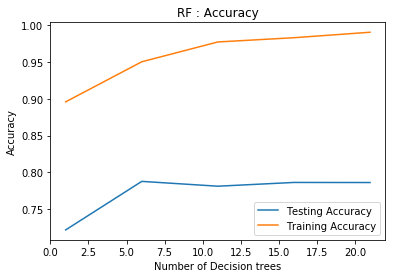

In [29]:
estimators = np.arange(1,25, 5)
train_acc = np.empty(len(estimators))
test_acc = np.empty(len(estimators))

for counter, values in enumerate(estimators):
    rf = make_pipeline(StandardScaler(),PCA(n_components= 3),RandomForestClassifier(n_estimators=values, criterion='entropy'))
    rf.fit(X_train, y_train)
    train_acc[counter] = rf.score(X_train, y_train)
    test_acc[counter] = rf.score(X_test, y_test)

plt.title('RF : Accuracy')
plt.plot(estimators, test_acc, label = 'Testing Accuracy')
plt.plot(estimators, train_acc, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Decision trees')
plt.ylabel('Accuracy')
plt.show()

## KNN is the optimal model

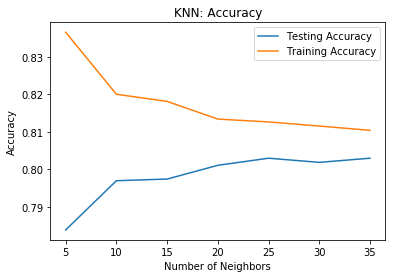

In [22]:
neighbors = np.arange(5,40, 5)
train_acc = np.empty(len(neighbors))
test_acc = np.empty(len(neighbors))

# test different K values

for counter, values in enumerate(neighbors):
    knn = make_pipeline(StandardScaler(),PCA(n_components=3),KNeighborsClassifier(n_neighbors=values))
    knn.fit(X_train, y_train)
    train_acc[counter] = knn.score(X_train, y_train)
    test_acc[counter] = knn.score(X_test, y_test)

### generate accuracy plot
plt.title('KNN: Accuracy')
plt.plot(neighbors, test_acc, label = 'Testing Accuracy')
plt.plot(neighbors, train_acc, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

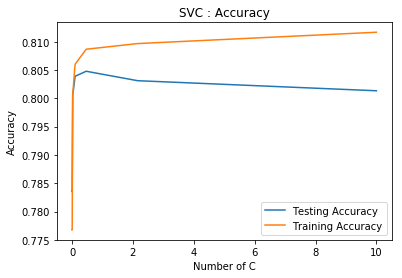

In [27]:
estimators = np.logspace(-5,1, 10)
train_acc = np.empty(len(estimators))
test_acc = np.empty(len(estimators))

for counter, values in enumerate(estimators):
    svc = make_pipeline(StandardScaler(),PCA(n_components= 3),SVC(C=values, kernel='rbf'))
    svc.fit(X_train, y_train)
    train_acc[counter] = svc.score(X_train, y_train)
    test_acc[counter] = svc.score(X_test, y_test)

plt.title('SVC : Accuracy')
plt.plot(estimators, test_acc, label = 'Testing Accuracy')
plt.plot(estimators, train_acc, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of C')
plt.ylabel('Accuracy')
plt.show()

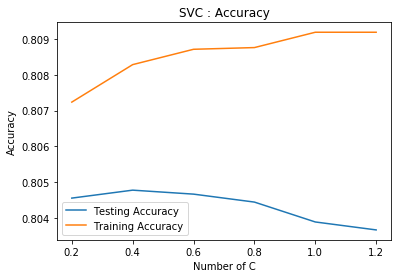

In [37]:
estimators = np.arange(.2,1.4, .2)
train_acc = np.empty(len(estimators))
test_acc = np.empty(len(estimators))

for counter, values in enumerate(estimators):
    svc = make_pipeline(StandardScaler(),PCA(n_components= 3),SVC(C=values,kernel='rbf'))
    svc.fit(X_train, y_train)
    train_acc[counter] = svc.score(X_train, y_train)
    test_acc[counter] = svc.score(X_test, y_test)

plt.title('SVC : Accuracy')
plt.plot(estimators, test_acc, label = 'Testing Accuracy')
plt.plot(estimators, train_acc, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of C')
plt.ylabel('Accuracy')
plt.show()

## model scoring

# KNN with n = 20 is the optimal model.

## It does not overfit the model and has better scores the SVC

## Model predictions

In [54]:
knn = make_pipeline(StandardScaler(), PCA(n_components=3), KNeighborsClassifier(n_neighbors = 20))
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
F1 = f1_score(y_test, knn_pred)

print('F1 score: %.3f' % F1)
print(confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred))


F1 score: 0.379
[[6672  380]
 [1403  545]]
             precision    recall  f1-score   support

          0       0.83      0.95      0.88      7052
          1       0.59      0.28      0.38      1948

avg / total       0.77      0.80      0.77      9000



In [ ]:
svc = make_pipeline(StandardScaler(), PCA(n_components=3), KNeighborsClassifier(n_neighbors = 20))
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
F1 = f1_score(y_test, knn_pred)

print('F1 score: %.3f' % F1)
print(confusion_matrix(y_test, knn_pred))
print(classification_report(y_test, knn_pred))
